In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import operator
#import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [3]:
train_df.shape

(4459, 4993)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [5]:
train_df.isnull().values.any()

False

In [6]:
test_df = pd.read_csv('test.csv')
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
test_df.shape

(49342, 4992)

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [9]:
test_df.isnull().values.any()

False

In [10]:
train_df_describe = train_df.describe()
train_df_describe

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,5.944923e+06,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,...,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,8.234312e+06,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,...,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.260000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+07,2.000000e+07,4.000000e+06,2.000000e+07,1.480000e+07,1.000000e+08,2.070800e+07,4.000000e+07,1.040000e+07,3.196120e+08,...,7.600000e+07,1.235880e+08,1.300000e+08,1.444000e+08,640000.000000,3.013120e+08,1.064200e+08,1.400000e+08,6.176800e+07,4.320000e+07


In [11]:
test_df_describe = test_df.describe()
test_df_describe

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,...,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04
mean,5.773787e+04,6.258726e+04,1.036752e+05,6.289853e+04,6.713354e+04,8.083879e+04,6.181014e+04,5.515752e+04,1.406324e+06,8.128668e+04,...,1.193910e+05,1.355955e+05,3.242217e+05,1.437856e+05,9.302367e+04,8.047145e+04,6.076865e+04,1.323210e+05,1.675766e+05,1.282487e+05
std,1.745182e+06,2.322787e+06,2.586951e+06,2.765941e+06,3.206124e+06,2.845031e+06,2.780137e+06,1.923517e+06,6.872366e+06,2.378938e+06,...,3.115190e+06,2.598454e+06,3.782996e+06,3.663374e+06,5.041000e+06,2.100210e+06,2.040655e+06,3.592018e+06,3.761816e+06,2.413798e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.504447e+08,2.283295e+08,2.758171e+08,3.972621e+08,4.667591e+08,2.852223e+08,4.863751e+08,2.043290e+08,3.435658e+08,2.310167e+08,...,5.351692e+08,1.236547e+08,3.793398e+08,4.025480e+08,9.657530e+08,1.680065e+08,2.497913e+08,3.200000e+08,3.186300e+08,2.189782e+08


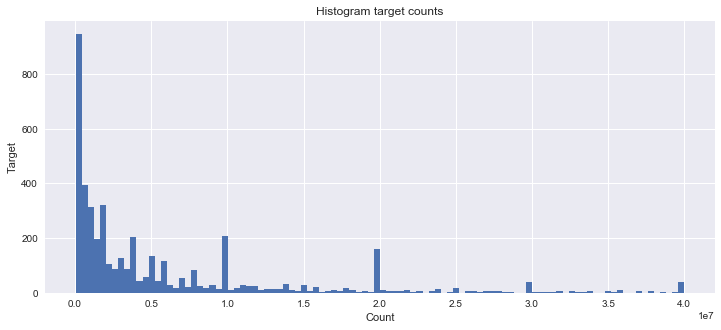

In [12]:
plt.figure(figsize=(12, 5))
plt.hist(train_df.target.values, bins=100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

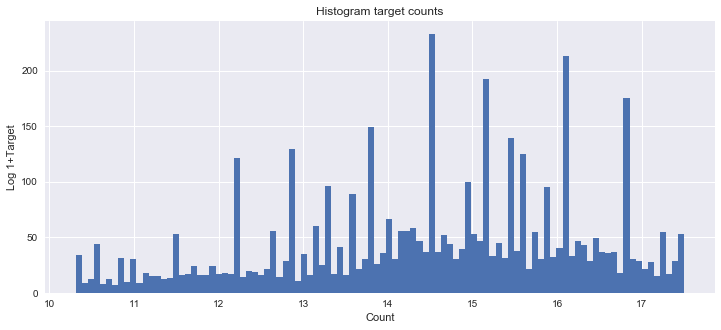

In [13]:
plt.figure(figsize=(12, 5))
plt.hist(np.log(1+train_df.target.values), bins=100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Log 1+Target')
plt.show()

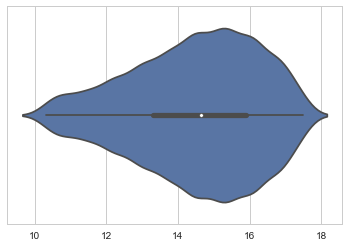

In [14]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=np.log(1+train_df.target.values))
plt.show()

In [15]:
train_log_target = train_df[['target']]
train_log_target['target'] = np.log(1+train_df['target'].values)
train_log_target.describe()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,target
count,4459.000000
mean,14.490239
std,1.750947
min,10.308986
25%,13.304687
50%,14.630876
75%,15.894952
max,17.504390


In [16]:
constant_train = train_df.loc[:, (train_df == train_df.iloc[0]).all()].columns.tolist()
constant_test = test_df.loc[:, (test_df == test_df.iloc[0]).all()].columns.tolist()

In [17]:
print('Number of constant columns in the train set:', len(constant_train))
print('Number of constant columns in the test set:', len(constant_test))

Number of constant columns in the train set: 256
Number of constant columns in the test set: 0


In [18]:
columns_to_use = test_df.columns.tolist()
del columns_to_use[0] # Remove 'ID'
columns_to_use = [x for x in columns_to_use if x not in constant_train] #Remove all 0 columns
len(columns_to_use)

4735

In [19]:
describe(train_df[columns_to_use].values, axis=None)

DescribeResult(nobs=21113365, minmax=(0.0, 4652000000.0), mean=293258.52559507504, variance=30028281996743.3, skewness=311.8700933184134, kurtosis=234173.65118899167)

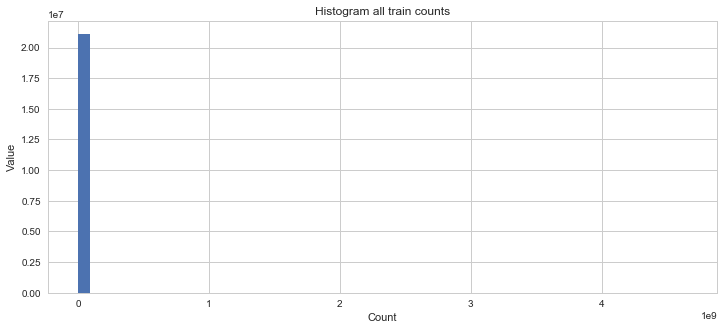

In [20]:
plt.figure(figsize=(12, 5))
plt.hist(train_df[columns_to_use].values.flatten(), bins=50)
plt.title('Histogram all train counts')
plt.xlabel('Count')
plt.ylabel('Value')
plt.show()

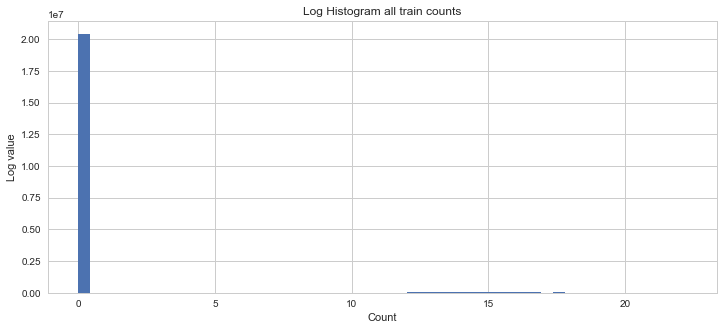

In [21]:
plt.figure(figsize=(12, 5))
plt.hist(np.log(train_df[columns_to_use].values.flatten()+1), bins=50)
plt.title('Log Histogram all train counts')
plt.xlabel('Count')
plt.ylabel('Log value')
plt.show()

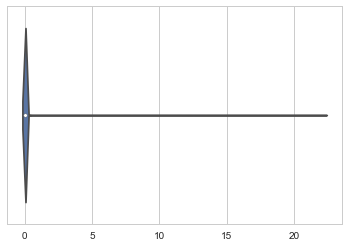

In [22]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=np.log(train_df[columns_to_use].values.flatten()+1))
plt.show()

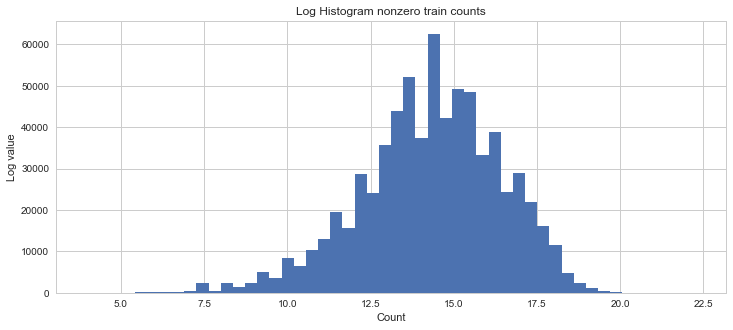

In [23]:
train_nz = np.log(train_df[columns_to_use].values.flatten()+1)
train_nz = train_nz[np.nonzero(train_nz)]
plt.figure(figsize=(12, 5))
plt.hist(train_nz, bins=50)
plt.title('Log Histogram nonzero train counts')
plt.xlabel('Count')
plt.ylabel('Log value')
plt.show()

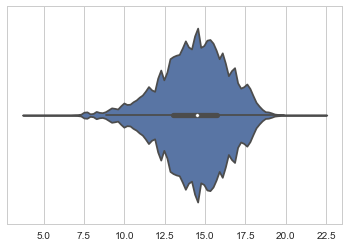

In [24]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=train_nz)
plt.show()

In [25]:
describe(train_nz)

DescribeResult(nobs=700109, minmax=(3.970291913552122, 22.260563071817792), mean=14.316623220268225, variance=4.4093394490175815, skewness=-0.4469438901987079, kurtosis=0.2590730075122565)

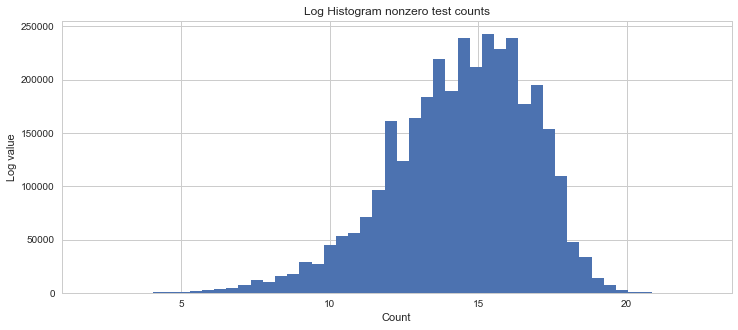

In [26]:
test_nz = np.log(test_df[columns_to_use].values.flatten()+1)
test_nz = test_nz[np.nonzero(test_nz)]
plt.figure(figsize=(12, 5))
plt.hist(test_nz, bins=50)
plt.title('Log Histogram nonzero test counts')
plt.xlabel('Count')
plt.ylabel('Log value')
plt.show()

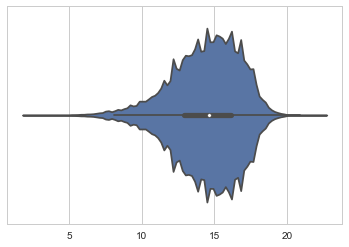

In [27]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=test_nz)
plt.show()

In [28]:
describe(test_nz)

DescribeResult(nobs=3402015, minmax=(2.0086157469070973, 22.503422149195277), mean=14.412378376537879, variance=5.547651949802501, skewness=-0.6259111391462195, kurtosis=0.3990742424795699)

In [29]:
train_df[columns_to_use].values.flatten().shape

(21113365,)

In [30]:
((train_df[columns_to_use].values.flatten())==0).mean()

0.9668404823200849

In [31]:
train_zeros = pd.DataFrame({'Percentile':((train_df[columns_to_use].values)==0).mean(axis=0),
                           'Column' : columns_to_use})
train_zeros.head()

,Column,Percentile
0,48df886f9,0.991254
1,0deb4b6a8,0.999103
2,34b15f335,0.992599
3,a8cb14b00,0.999551
4,2f0771a37,0.998879


In [32]:
describe(train_zeros.Percentile.values)

DescribeResult(nobs=4735, minmax=(0.6490244449428123, 0.999775734469612), mean=0.9668404823200848, variance=0.002364379746472081, skewness=-3.0652241198889913, kurtosis=12.91866341515125)

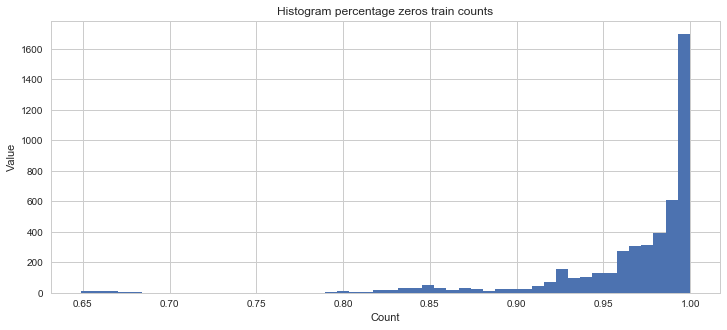

In [34]:
plt.figure(figsize=(12, 5))
plt.hist(train_zeros.Percentile.values, bins=50)
plt.title('Histogram percentage zeros train counts')
plt.xlabel('Count')
plt.ylabel('Value')
plt.show()

In [35]:
describe(np.log(train_df[columns_to_use].values+1), axis=None)

DescribeResult(nobs=21113365, minmax=(0.0, 22.260563071817792), mean=0.4747323207891672, variance=6.717404669554313, skewness=5.38608469493144, kurtosis=27.58080786335338)

In [36]:
describe(test_df[columns_to_use].values, axis=None)

DescribeResult(nobs=233634370, minmax=(0.0, 5930783399.23079), mean=168464.1181982833, variance=19686658498586.707, skewness=297.586650843169, kurtosis=260104.68553477703)

In [37]:
describe(np.log(test_df[columns_to_use].values+1), axis=None)

DescribeResult(nobs=233634370, minmax=(0.0, 22.503422149195277), mean=0.20986264744633906, variance=3.0613584426687614, skewness=8.406607428136079, kurtosis=70.08947561815806)

In [38]:
test_zeros = pd.DataFrame({'Percentile':(np.log(1+test_df[columns_to_use].values)==0).mean(axis=0),
                           'Column' : columns_to_use})
test_zeros.head()

,Column,Percentile
0,48df886f9,0.994204
1,0deb4b6a8,0.996028
2,34b15f335,0.989218
3,a8cb14b00,0.995866
4,2f0771a37,0.996352


In [39]:
describe(test_zeros.Percentile.values)

DescribeResult(nobs=4735, minmax=(0.8368327185764664, 0.9966965262859228), mean=0.9854387220510409, variance=0.0003225586648390302, skewness=-3.8759625696317483, kurtosis=20.273655656625518)